## Bassmatrix Beamsteering Directivity Plots

# Non-dynamic Calculations with visualisation

In [ ]:
# imports in code cells. Not efficient but crucial for GUI

# execute cells individually with imports to guarantuee flawless workflow

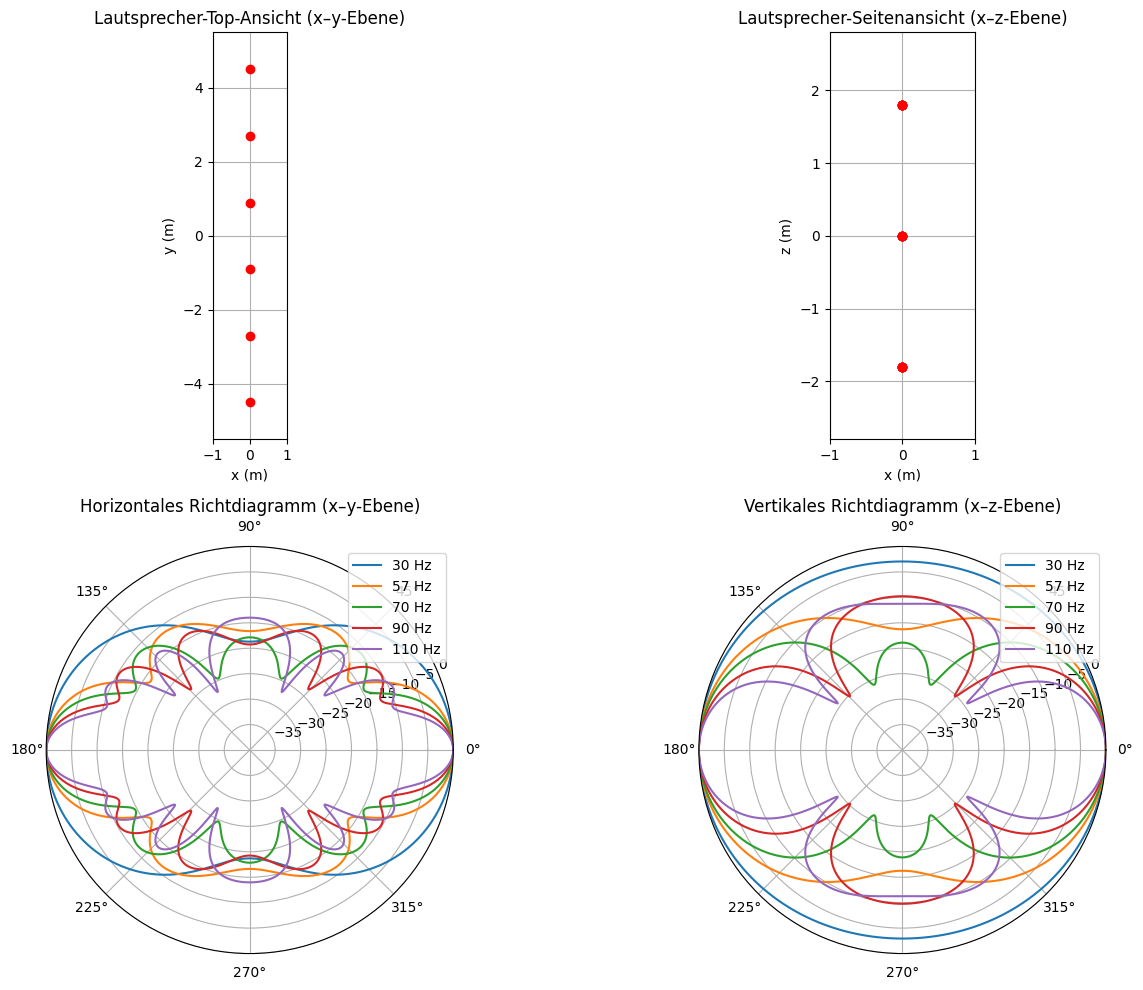

In [1]:
# imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider


def get_delay_for_z(z):
    """
    Gibt ein elektronisches Delay (in Sekunden) basierend auf der vertikalen Position zurück.
    Unterste Reihe: größtes Delay
    Mittlere Reihe: mittleres Delay
    Oberste Reihe: kein Delay
    """
    delay_per_step = -0.00 # z.B. -1 ms pro Stufe

    z_levels = sorted(z_positions)
    index = z_levels.index(z)  # 0 = unten, 1 = mitte, 2 = oben
    return index * delay_per_step



# Parameter
horizontal_speakers = 6
vertical_speakers = 3
dy = 1.8  # horizontaler Abstand (y)
dz = 1.8  # vertikaler Abstand (z)
r_obs = 20  # Radius des Beobachtungskreises
v = 0.1  # Kolbengeschwindigkeit
R = 0.38 / 2
f = [30, 57, 70, 90, 110]
rho = 1.204
c = 343
q = np.pi * v * R**2

theta = np.linspace(0, 2*np.pi, 720)

# Lautsprecherpositionen (in yz-Ebene, x=0)
y_positions = np.linspace(-(horizontal_speakers - 1) / 2 * dy, (horizontal_speakers - 1) / 2 * dy, horizontal_speakers)
z_positions = np.linspace(-(vertical_speakers - 1) / 2 * dz, (vertical_speakers - 1) / 2 * dz, vertical_speakers)
speaker_positions = [(0, y, z) for z in z_positions for y in y_positions]



# Subplot Setup: 2x2
fig = plt.figure(figsize=(14, 10))

# Top-View subplot (xy, z=0)
ax_top = fig.add_subplot(2, 2, 1)
ax_top.set_title("Lautsprecher-Top-Ansicht (x–y-Ebene)")
for (_, y, z) in speaker_positions:
    if np.isclose(z, 0):  # nur Lautsprecher mit z=0
        ax_top.plot(0, y, 'ro')
ax_top.set_xlabel("x (m)")
ax_top.set_ylabel("y (m)")
ax_top.set_xlim(-1, 1)
ax_top.set_ylim(min(y_positions)-1, max(y_positions)+1)
ax_top.grid(True)
ax_top.set_aspect('equal')

# Side-View subplot (xz, y=0)
ax_side = fig.add_subplot(2, 2, 2)
ax_side.set_title("Lautsprecher-Seitenansicht (x–z-Ebene)")

for (_, y, z) in speaker_positions:
    ax_side.plot(0, z, 'ro')  # alle Lautsprecher – Position entlang z

ax_side.set_xlabel("x (m)")
ax_side.set_ylabel("z (m)")
ax_side.set_xlim(-1, 1)
ax_side.set_ylim(min(z_positions)-1, max(z_positions)+1)
ax_side.grid(True)
ax_side.set_aspect('equal')





# Polarplot Horizontal (x–y)``
ax_polar_h = fig.add_subplot(2, 2, 3, projection='polar')
ax_polar_h.set_title("Horizontales Richtdiagramm (x–y-Ebene)")

# Polarplot Vertikal (x–z)
ax_polar_v = fig.add_subplot(2, 2, 4, projection='polar')
ax_polar_v.set_title("Vertikales Richtdiagramm (x–z-Ebene)")

for freq in f:
    w = 2 * np.pi * freq
    k = w / c

    # Horizontal (x–y)
    x_r_h = r_obs * np.cos(theta)
    y_r_h = r_obs * np.sin(theta)
    z_r_h = 0
    p_total_h = np.zeros_like(theta, dtype=complex)

    for (x_s, y_s, z_s) in speaker_positions:
        r_n = np.sqrt((x_r_h - x_s)**2 + (y_r_h - y_s)**2 + (z_r_h - z_s)**2)
        delay = get_delay_for_z(z_s)
        phase_delay = np.exp(-1j * w * delay)
        p_n = q * (1j * w * rho) / (4 * np.pi * r_n) * np.exp(-1j * k * r_n) * phase_delay
        p_total_h += p_n

    G_h = abs(p_total_h) / np.max(abs(p_total_h))
    ax_polar_h.plot(theta, 20 * np.log10(G_h), label=f'{freq} Hz')

    # Vertikal (x–z)
    x_r_v = r_obs * np.cos(theta)
    z_r_v = r_obs * np.sin(theta)
    y_r_v = 0
    p_total_v = np.zeros_like(theta, dtype=complex)

    for (x_s, y_s, z_s) in speaker_positions:
        r_n = np.sqrt((x_r_v - x_s)**2 + (y_r_v - y_s)**2 + (z_r_v - z_s)**2)
        delay = get_delay_for_z(z_s)
        phase_delay = np.exp(-1j * w * delay)
        p_n = q * (1j * w * rho) / (4 * np.pi * r_n) * np.exp(-1j * k * r_n) * phase_delay
        p_total_v += p_n

    G_v = abs(p_total_v) / np.max(abs(p_total_v))
    ax_polar_v.plot(theta, 20 * np.log10(G_v), label=f'{freq} Hz')

for ax in [ax_polar_h, ax_polar_v]:
    ax.set_ylim(-40, 0)
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Dynamic Calculations with GUI


## vertical plane, linear increment of delay

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, CheckButtons
import matplotlib
matplotlib.use('TkAgg')

# Parameter
horizontal_speakers = 6
vertical_speakers = 3
dy = 1.8
dz = 1.8
r_obs = 20
v = 0.1
R = 0.38 / 2
rho = 1.204
c = 343
q = np.pi * v * R**2
theta = np.linspace(0, 2 * np.pi, 720)
freq_range = (30, 200)

# Lautsprecherpositionen
y_positions = np.linspace(-(horizontal_speakers - 1) / 2 * dy,
                          (horizontal_speakers - 1) / 2 * dy, horizontal_speakers)
z_positions = np.linspace(-(vertical_speakers - 1) / 2 * dz,
                          (vertical_speakers - 1) / 2 * dz, vertical_speakers)
speaker_positions = [(0, y, z) for z in z_positions for y in y_positions]

# Plot Setup
fig = plt.figure(figsize=(12, 8))
plt.subplots_adjust(bottom=0.35)

# Richtdiagramm (polar)
ax_polar = fig.add_subplot(2, 2, 2, projection='polar')
plot_line, = ax_polar.plot(theta, np.zeros_like(theta), label='dB')
ax_polar.set_ylim(-40, 0)
ax_polar.set_title("Vertikales Richtdiagramm (x–z-Ebene)")
ax_polar.plot(theta, np.full_like(theta, -20), '--k', linewidth=0.8)

# Seitenansicht
ax_side = fig.add_subplot(2, 2, 1)
ax_side.set_title("Seitenansicht Lautsprecher (x–z)")
ax_side.set_xlim(-1, 1)
ax_side.set_ylim(min(z_positions) - 1, max(z_positions) + 1)
ax_side.set_xlabel("x (m)")
ax_side.set_ylabel("z (m)")
ax_side.grid(True)

# Slider für Frequenz
freq_ax = plt.axes([0.25, 0.08, 0.5, 0.03])
freq_slider = Slider(freq_ax, 'Frequenz [Hz]', freq_range[0], freq_range[1], valinit=110, valstep=1)

# Delay-Slider + Phasen-Switches
delay_sliders = []
phase_inverts = [False] * vertical_speakers  # Start: keine Invertierung
slider_height = 0.03
slider_spacing = 0.01
start_y = 0.15

# Phasen-Buttons speichern
check_axes = []
check_buttons = []

for i, z in enumerate(z_positions):
    # Delay-Slider
    ax_delay = plt.axes([0.25, start_y + i * (slider_height + slider_spacing), 0.4, slider_height])
    slider = Slider(ax_delay, f'Delay z={z:.2f} m [ms]', -3.0, 3.0, valinit=0.0, valstep=0.1)
    delay_sliders.append(slider)

    # Phaseninvertierungsschalter
    ax_check = plt.axes([0.67, start_y + i * (slider_height + slider_spacing), 0.15, slider_height])
    btn = CheckButtons(ax_check, ['Invertieren'], [False])
    check_axes.append(ax_check)
    check_buttons.append(btn)

# Update-Funktion
def update(val):
    delays_ms = [slider.val for slider in delay_sliders]
    delays_s = [d / 1000 for d in delays_ms]
    invert_flags = [btn.get_status()[0] for btn in check_buttons]

    freq = freq_slider.val
    w = 2 * np.pi * freq
    k = w / c

    x_r = r_obs * np.cos(theta)
    z_r = r_obs * np.sin(theta)
    y_r = 0
    p_total = np.zeros_like(theta, dtype=complex)

    z_levels = list(z_positions)

    def get_delay(z):
        index = z_levels.index(z)
        return delays_s[index]

    def is_inverted(z):
        index = z_levels.index(z)
        return invert_flags[index]

    # Berechnung
    for (x_s, y_s, z_s) in speaker_positions:
        r_n = np.sqrt((x_r - x_s)**2 + (y_r - y_s)**2 + (z_r - z_s)**2)
        delay = get_delay(z_s)
        phase = np.exp(-1j * w * delay)

        if is_inverted(z_s):
            phase *= -1  # 180° Phasenverschiebung

        p_n = q * (1j * w * rho) / (4 * np.pi * r_n) * np.exp(-1j * k * r_n) * phase
        p_total += p_n

    G = abs(p_total) / np.max(abs(p_total))
    G_dB = 20 * np.log10(G + 1e-12)
    plot_line.set_ydata(G_dB)

    # Seitenansicht aktualisieren
    ax_side.clear()
    ax_side.set_title("Seitenansicht Lautsprecher (x–z)")
    ax_side.set_xlim(-1, 1)
    ax_side.set_ylim(min(z_positions) - 1, max(z_positions) + 1)
    ax_side.set_xlabel("x (m)")
    ax_side.set_ylabel("z (m)")
    ax_side.grid(True)

    center_y = min(y_positions, key=lambda y: abs(y))
    for (x_s, y_s, z_s) in speaker_positions:
        if np.isclose(y_s, center_y):
            delay_ms = get_delay(z_s) * 1000
            invert = is_inverted(z_s)
            label = f"{delay_ms:.1f} ms" + (" INV" if invert else "")
            ax_side.plot(x_s, z_s, 'ro')
            ax_side.text(x_s + 0.1, z_s, label, va='center', fontsize=9, color='black')

    fig.canvas.draw_idle()

# Event-Handler
for s in delay_sliders:
    s.on_changed(update)
for btn in check_buttons:
    btn.on_clicked(update)
freq_slider.on_changed(update)

# Initialanzeige
update(None)
plt.show()

: 

## lateral plane, 'circular delay curvature'

In [8]:
# imports
import matplotlib
matplotlib.use('TkAgg')  # Für lokale Ausführung außerhalb von Jupyter

# Parameter
horizontal_speakers = 6
vertical_speakers = 3
dy = 1.8
dz = 1.8
r_obs = 20
v = 0.1
R = 0.38 / 2
rho = 1.204
c = 343
q = np.pi * v * R**2
theta = np.linspace(0, 2 * np.pi, 720)
freq_range = (30, 200)

# Positionen
y_positions = np.linspace(-(horizontal_speakers - 1) / 2 * dy,
                          (horizontal_speakers - 1) / 2 * dy, horizontal_speakers)
z_positions = np.linspace(-(vertical_speakers - 1) / 2 * dz,
                          (vertical_speakers - 1) / 2 * dz, vertical_speakers)
speaker_positions = [(0, y, z) for z in z_positions for y in y_positions]

# GUI Setup
fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[5, 1])
plt.subplots_adjust(bottom=0.25)

# Top-View
ax_top = fig.add_subplot(gs[0, 0])
ax_top.set_title("Top-Ansicht Lautsprecher (x–y)")
delay_texts = []

# Polarplot (Richtdiagramm)
ax_polar = fig.add_subplot(gs[0, 1], projection='polar')
plot_line, = ax_polar.plot(theta, np.zeros_like(theta), label='dB')
ax_polar.set_ylim(-40, 0)
ax_polar.set_title("Horizontales Richtdiagramm (x–y)")
ax_polar.plot(theta, np.full_like(theta, -20), '--k', linewidth=0.8)
ax_polar.legend(loc='upper right')

# Sliders
delay_ax = fig.add_axes([0.25, 0.13, 0.5, 0.03])
delay_slider = Slider(delay_ax, 'Max Delay Mitte [ms]', 0.0, 3.0, valinit=1.5, valstep=0.1)

freq_ax = fig.add_axes([0.25, 0.06, 0.5, 0.03])
freq_slider = Slider(freq_ax, 'Frequenz [Hz]', freq_range[0], freq_range[1], valinit=110, valstep=1)


def update(val):
    max_delay = delay_slider.val / 1000
    freq = freq_slider.val
    w = 2 * np.pi * freq
    k = w / c

    x_r = r_obs * np.cos(theta)
    y_r = r_obs * np.sin(theta)
    z_r = 0
    p_total = np.zeros_like(theta, dtype=complex)

    max_y = max(abs(y_positions))

    def get_delay(y):
        return max_delay * (1 - abs(y) / max_y)

    delays = []
    for (x_s, y_s, z_s) in speaker_positions:
        r_n = np.sqrt((x_r - x_s)**2 + (y_r - y_s)**2 + (z_r - z_s)**2)
        delay = get_delay(y_s)
        delays.append(delay * 1000)
        phase_delay = np.exp(-1j * w * delay)
        p_n = q * (1j * w * rho) / (4 * np.pi * r_n) * np.exp(-1j * k * r_n) * phase_delay
        p_total += p_n

    G = abs(p_total) / np.max(abs(p_total))
    G_dB = 20 * np.log10(G + 1e-12)
    plot_line.set_ydata(G_dB)

    # --- Update Top-View ---
    ax_top.clear()
    ax_top.set_title("Top-Ansicht Lautsprecher (x–y)")
    ax_top.set_xlim(-1, 1)
    ax_top.set_ylim(min(y_positions) - 1, max(y_positions) + 1)
    ax_top.set_xlabel("x (m)")
    ax_top.set_ylabel("y (m)")
    ax_top.grid(True)

    # Nur z = 0 Lautsprecher darstellen
    global delay_texts
    delay_texts = []
    for (x_s, y_s, z_s) in speaker_positions:
        if np.isclose(z_s, 0):
            delay_ms = get_delay(y_s) * 1000
            ax_top.plot(x_s, y_s, 'ro')
            txt = ax_top.text(x_s + 0.1, y_s, f"{delay_ms:.1f} ms", va='center', fontsize=9, color='black')
            delay_texts.append(txt)

    fig.canvas.draw_idle()


# Initialisieren
update(None)
delay_slider.on_changed(update)
freq_slider.on_changed(update)

plt.show()